In [5]:
import raster_geometry as rg
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
import pickle
import sys
sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
import itertools
from joblib import Parallel, delayed
from skimage.morphology import opening
from PIL import Image       
import pymunk


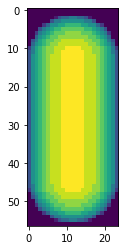

In [2]:
def raster_cell(length, width):
    radius = int(width/2)
    cyl_height = int(length - 2*radius)
    shape = 200 #200
    cylinder = rg.cylinder(
            shape = shape,
            height = cyl_height,
            radius = radius,
            axis=0,
            position=(0.5,0.5,0.5),
            smoothing=False)

    sphere1 = rg.sphere(shape,radius,((shape + cyl_height)/(2*shape),0.5,0.5))
    sphere2 = rg.sphere(shape,radius,((shape - cyl_height)/(2*shape),0.5,0.5))


    cell = (cylinder + sphere1 + sphere2)
    cell = cell[int(shape/2-cyl_height/2-radius-1):int(shape/2+cyl_height/2+radius+1),
                int(shape/2)-radius:int(shape/2)+radius,
               int(shape/2)-radius:int(shape/2)+radius]
    z,x,y = cell.nonzero()
    OPL_cell = np.sum(cell,axis=2)
    return OPL_cell

OPL_cell = raster_cell(length = 55, width=25)
plt.imshow(OPL_cell)
plt.show()

In [ ]:
with open("../output_pickles/space.p", "rb") as f:
    space = pickle.load(f)

In [ ]:
plt.figure(figsize=(1,10))
for body, shape in zip(space.bodies, space.shapes):
    if body.body_type == 0:
        vertices = []
        for v in shape.get_vertices():
            x,y = v.rotated(shape.body.angle) + shape.body.position #.rotated(self.shape.body.angle)
            vertices.append((x,y))
        vertices = np.array(vertices)
        
        plt.scatter(vertices[:,0], vertices[:,1])


In [6]:
def get_distance(vertex1, vertex2):
    return abs(np.sqrt((vertex1[0]-vertex2[0])**2 + (vertex1[1]-vertex2[1])**2))

def find_farthest_vertices(vertex_list):
    vertex_combs = list(itertools.combinations(vertex_list, 2))
    distance = 0
    farthest_vertices = 0
    for vertex_comb in vertex_combs:
        distance_ = get_distance(vertex_comb[0],vertex_comb[1])
        if distance_ > distance:
            distance = distance_
            farthest_vertices = vertex_comb
    return np.array(farthest_vertices)

def get_midpoint(vertex1, vertex2):
    x_mid = (vertex1[0]+vertex2[0])/2
    y_mid = (vertex1[1]+vertex2[1])/2
    return np.array([x_mid,y_mid])

def vertices_slope(vertex1, vertex2):
    return (vertex1[1] - vertex2[1])/(vertex1[0] - vertex2[0])

def midpoint_intercept(vertex1, vertex2):
    midpoint = get_midpoint(vertex1, vertex2)
    slope = vertices_slope(vertex1, vertex2)
    intercept = midpoint[1]-(slope*midpoint[0])
    return intercept

def get_centroid(vertices: list[tuple]) -> tuple:
    """Return the centroid of a list of vertices 
    
    Keyword arguments:
    vertices -- A list of tuples containing x,y coordinates.

    """
    return np.sum(vertices,axis=0)/len(vertices)

def place_cell(length, width, angle, position, space):
    angle = np.rad2deg(angle)
    x, y = np.array(position).astype(int)
    OPL_cell = raster_cell(length = length, width=width)
    rotated_OPL_cell = rotate(OPL_cell,angle,resize=True,clip=False,preserve_range=True)
    cell_y, cell_x = (np.array(rotated_OPL_cell.shape)/2).astype(int)
    offset_y = rotated_OPL_cell.shape[0] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[0]
    offset_x = rotated_OPL_cell.shape[1] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]
    space[y-cell_y+100:y+cell_y+offset_y+100,x-cell_x+100:x+cell_x+offset_x+100] += rotated_OPL_cell

In [ ]:
plt.figure(figsize=(2,4))
plt.scatter(above_vertices[:,0], above_vertices[:,1])
plt.scatter(farthest_vertices[:,0], farthest_vertices[:,1])
plt.scatter(midpoint[0], midpoint[1])
plt.plot

In [ ]:
plt.figure(figsize=(1,10))
for body, shape in zip(space.bodies, space.shapes):
    if body.body_type == 0:
        vertices = []
        for v in shape.get_vertices():
            x,y = v.rotated(shape.body.angle) + shape.body.position #.rotated(self.shape.body.angle)
            vertices.append((x,y))
        vertices = np.array(vertices)
        
        plt.scatter(vertices[:,0], vertices[:,1])


In [ ]:
with open("../output_pickles/cell_timeseries.p", "rb") as f:
    cell_timeseries = pickle.load(f)
cell_timeseries_properties = []
for cell_timeseries_lists in cell_timeseries:
    cell_properties = []
    for cell in cell_timeseries_lists:
        body, shape = (cell.body, cell.shape)
        vertices = []
        for v in shape.get_vertices():
            x,y = v.rotated(shape.body.angle) + shape.body.position #.rotated(self.shape.body.angle)
            vertices.append((x,y))
        vertices = np.array(vertices)

        centroid = get_centroid(vertices) 
        farthest_vertices = find_farthest_vertices(vertices)
        length = get_distance(farthest_vertices[0],farthest_vertices[1])
        width = cell.width
        angle = np.arctan(vertices_slope(farthest_vertices[0], farthest_vertices[1]))
        cell_properties.append([length, width, angle, centroid])
    cell_timeseries_properties.append(cell_properties)

In [7]:
def gen_cell_props_for_draw(cell_timeseries_lists):
    cell_properties = []
    for cell in cell_timeseries_lists:
        body, shape = (cell.body, cell.shape)
        vertices = []
        for v in shape.get_vertices():
            x,y = v.rotated(shape.body.angle) + shape.body.position #.rotated(self.shape.body.angle)
            vertices.append((x,y))
        vertices = np.array(vertices)

        centroid = get_centroid(vertices) 
        farthest_vertices = find_farthest_vertices(vertices)
        length = get_distance(farthest_vertices[0],farthest_vertices[1])
        width = cell.width
        angle = np.arctan(vertices_slope(farthest_vertices[0], farthest_vertices[1]))
        cell_properties.append([length, width, angle, centroid])
    return cell_properties

In [8]:
with open("../output_pickles/cell_timeseries.p", "rb") as f:
    cell_timeseries = pickle.load(f)
cell_timeseries_properties = Parallel(n_jobs=15)(delayed(gen_cell_props_for_draw)(a) for a in cell_timeseries)

In [13]:
def draw_scene(cell_properties):
    upscale = 1
    space_size = np.array([800, 170]) * upscale
    space = np.zeros(space_size)
    space_masks = np.zeros(space_size)
    offsets = 30 * upscale
    for properties in cell_properties:
        length, width, angle, position = properties
        length = length*upscale; width = width * upscale; position = np.array(position) * upscale
        angle = np.rad2deg(angle) + 90
        x, y = np.array(position).astype(int) + offsets
        OPL_cell = raster_cell(length = length, width=width)
        rotated_OPL_cell = rotate(OPL_cell,angle,resize=True,clip=False,preserve_range=True)
        cell_y, cell_x = (np.array(rotated_OPL_cell.shape)/2).astype(int)
        offset_y = rotated_OPL_cell.shape[0] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[0]
        offset_x = rotated_OPL_cell.shape[1] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]
        space[y-cell_y:y+cell_y+offset_y,x-cell_x:x+cell_x+offset_x] += rotated_OPL_cell
        space_masks[y-cell_y:y+cell_y+offset_y,x-cell_x:x+cell_x+offset_x] += (rotated_OPL_cell > 7)
        space_masks = space_masks == 1
        space_masks = opening(space_masks,np.ones((1,8)))
    return space, space_masks

In [14]:
output_dir = "/home/georgeos/Documents/GitHub/SYMPTOMM2/OPL_renders/"
scenes = Parallel(n_jobs=14)(delayed(draw_scene)(cell_properties) for cell_properties in cell_timeseries_properties)

In [15]:
def scene_plotter(scene_array,output_dir,name,a,matplotlib_draw):
    if matplotlib_draw == True:
        plt.figure(figsize=(3,10))
        plt.imshow(scene_array)
        plt.tight_layout()
        plt.savefig(output_dir+"/{}_{}.png".format(name,str(a).zfill(3)))
        plt.clf()
        plt.close('all')
    else:
        im = Image.fromarray(scene_array.astype(np.uint8))
        im.save(output_dir+"/{}_{}.tif".format(name,str(a).zfill(3)))

In [16]:
_ = Parallel(n_jobs=13)(delayed(scene_plotter)(scenes[x][0],output_dir,"OPL",x,matplotlib_draw=False) for x in range(len(scenes)))